# Hyperparameter search for STalign2: 
## Align two MERFISH brain sections using modified LDDMM with affine transformation on cell density and gene exp.
#### Version: Using manual landmark points. 

Data source: Vizgen Data Release V1.0. May 2021 (https://info.vizgen.com/mouse-brain-map?submissionGuid=955163f1-3119-42d9-bcbf-e0255e6e7d17) 

Dataset used: Slice 2 Replicate 2, Slice 2 Replicate 3 

Code: Iris Kwon (skwon38@jh.edu)

In [1]:
import os
import matplotlib.pyplot as plt
##### %%time
import torch
import copy
from torch.nn.functional import grid_sample
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad 
import landmark as lm 
import STalign
# from STalign import STalign
dir(STalign)

/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/anndata/_core/anndata.py:22: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy import sparse
/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (None)/charset_normalizer (3.4.4) doesn't match a supported version!
  warnings.warn(


['LDDMM',
 'LDDMM_3D_to_slice',
 'L_T_from_points',
 'Line2D',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'analyze3Dalign',
 'build_transform',
 'build_transform3D',
 'calculate_tre',
 'clip',
 'cm',
 'copy',
 'defaultdict',
 'download_aba_image_labels',
 'download_aba_ontology',
 'exists',
 'extent_from_x',
 'glob',
 'go',
 'grid_sample',
 'interp',
 'interp3D',
 'join',
 'make_scree',
 'makedirs',
 'normalize',
 'np',
 'nrrd',
 'os',
 'pd',
 'plot_brain_regions',
 'plot_subset_brain_regions',
 'plt',
 'px',
 'rasterize',
 'rasterizePCA',
 'rasterize_with_signal',
 'requests',
 'saveRasters',
 'split',
 'splitext',
 'sys',
 'to_A',
 'to_A_3D',
 'torch',
 'tornado',
 'transform_image_source_to_target',
 'transform_image_source_with_A',
 'transform_image_target_to_source',
 'transform_points_source_to_target',
 'transform_points_target_to_source',
 'v_to_phii',
 'v_to_phii_3D']

In [2]:
def normalize(arr, t_min=0, t_max=1):
    """Linearly normalizes an array between two specifed values.
    
    Parameters
    ----------
    arr : numpy array
        array to be normalized
    t_min : int or float
        Lower bound of normalization range
    t_max : int or float
        Upper bound of normalization range
    
    Returns
    -------
    norm_arr : numpy array
        1D array with normalized arr values
        
    """
    
    diff = t_max - t_min
    diff_arr = np.max(arr) - np.min(arr)
    min_ = np.min(arr)
    if diff_arr != 0:
        norm_arr = ((arr - min_)/diff_arr * diff) + t_min
    else:
        norm_arr = np.zeros(arr.shape)
    
    return norm_arr


def rasterize(x, y, g=np.ones(1), dx=15, blur=1.5, expand=1.2, draw=0, wavelet_magnitude=False,use_windowing=True):
    ''' Rasterize a spatial transcriptomics dataset into a density image
    
    Paramters
    ---------
    x : numpy array of length N
        x location of cells
    y : numpy array of length N
        y location of cells
    g : numpy array of length N
        RNA count of cells
        If not given, density image is created
    dx : float
        Pixel size to rasterize data (default 30.0, in same units as x and y)
    blur : float or list of floats
        Standard deviation of Gaussian interpolation kernel.  Units are in 
        number of pixels.  Can be aUse a list to do multi scale.
    expand : float
        Factor to expand sampled area beyond cells. Defaults to 1.1.
    draw : int
        If True, draw a figure every draw points return its handle. Defaults to False (0).
    wavelet_magnitude : bool
        If True, take the absolute value of difference between scales for raster images.
        When using this option blur should be sorted from greatest to least.
    
        
    Returns
    -------
    X  : numpy array
        Locations of pixels along the x axis
    Y  : numpy array
        Locations of pixels along the y axis
    M : numpy array
        A rasterized image with len(blur) channels along the first axis
    fig : matplotlib figure handle
        If draw=True, returns a figure handle to the drawn figure.
        
    Raises
    ------    
    Exception 
        If wavelet_magnitude is set to true but blur is not sorted from greatest to least.
        
        
    
    Examples
    --------
    Rasterize a dataset at 30 micron pixel size, with three kernels.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000)
    
    Rasterize a dataset at 30 micron pixel size, with three kernels, using difference between scales.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000, wavelet_magnitude=True)
        
        
    '''
    
    # set blur to a list
    if not isinstance(blur,list):
        blur = [blur]
    nb = len(blur)
    blur = np.array(blur)
    n = len(x)
    maxblur = np.max(blur) # for windowing
    
    
    
    if wavelet_magnitude and np.any(blur != np.sort(blur)[::-1]):
        raise Exception('When using wavelet magnitude, blurs must be sorted from greatest to least')
    
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
    miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand
    X_ = np.arange(minx,maxx,dx)
    Y_ = np.arange(miny,maxy,dx)
    
    X = np.stack(np.meshgrid(X_,Y_)) # note this is xy order, not row col order

    W = np.zeros((X.shape[1],X.shape[2],nb))

    
    if draw: fig,ax = plt.subplots()
    count = 0
    
    g = np.resize(g,x.size)
    if(not (g==1.0).all()):
        g = normalize(g)
    #if np.sum(g) == 0:
    #    print('no gene exp')
    #    return X,Y,W, None
    for x_,y_,g_ in zip(x,y,g):
        # to speed things up I should index
        # to do this I'd have to find row and column indices
        #col = np.round((x_ - X_[0])/dx).astype(int)
        #row = np.round((y_ - X_[1])/dx).astype(int)
        #row0 = np.floor(row-blur*3).astype(int)
        #row1 = np.ceil(row+blur*3).astype(int)        
        #rows = np.arange(row0,row1+1)
        

        # this is incrementing one pixel at a time, it is way way faster, 
        # but doesn't use a kernel
        # I[c_,row,col] += 1.0
        # W[row,col] += 1.0
        if not use_windowing: # legacy version
            k = np.exp( - ( (X[0][...,None] - x_)**2 + (X[1][...,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)    
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]

            W += k
        else: # use a small window
            r = int(np.ceil(maxblur*4))
            col = np.round((x_ - X_[0])/dx).astype(int)
            row = np.round((y_ - Y_[0])/dx).astype(int)
            
            row0 = np.floor(row-r).astype(int)
            row1 = np.ceil(row+r).astype(int)                    
            col0 = np.floor(col-r).astype(int)
            col1 = np.ceil(col+r).astype(int)
            
            # we need boundary conditions
            row0 = np.minimum(np.maximum(row0,0),W.shape[0]-1)
            row1 = np.minimum(np.maximum(row1,0),W.shape[0]-1)
            col0 = np.minimum(np.maximum(col0,0),W.shape[1]-1)
            col1 = np.minimum(np.maximum(col1,0),W.shape[1]-1)
            
           
            k =  np.exp( - ( (X[0][row0:row1+1,col0:col1+1,None] - x_)**2 + (X[1][row0:row1+1,col0:col1+1,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)  
            else:
                k=k
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]
            W[row0:row1+1,col0:col1+1,:] += k #range of voxels -oka
            
        
            
        

        if draw:
            if not count%draw or count==(x.shape[0]-1):
                print(f'{count} of {x.shape[0]}')

                ax.cla()
                toshow = W-np.min(W,axis=(0,1),keepdims=True)
                toshow = toshow / np.max(toshow,axis=(0,1),keepdims=True)
                
                if nb >= 3:
                    toshow = toshow[...,:3]
                elif nb == 2:
                    toshow = toshow[...,[0,1,0]]
                elif nb == 1:
                    toshow = toshow[...,[0,0,0]]
                
                ax.imshow(np.abs(toshow))
                fig.canvas.draw()

        count += 1
    W = np.abs(W)
    # we will permute so channels are on first axis
    W = W.transpose((-1,0,1))
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])
    
    # rename
    X = X_
    Y = Y_
    if draw:
        output = X,Y,W,fig
    else:
        output = X,Y,W
    return output

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T
    
import torch

def to_A(L,T):
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

def extent_from_x(xJ): #bounds for image to plot - ok
    dJ = [x[1]-x[0] for x in xJ] #step size between pixels along the axes - but is this difference between x and y?
    extentJ = ((xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    
    return extentJ

def clip(I):

    Ic = torch.clone(I)
    Ic[Ic<0]=0
    Ic[Ic>1]=1
    return Ic

def interp(x,I,phii,**kwargs):
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

def rasterizeByGene(x, y, G, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True):
    nrows=0
    ncols=0
    
    for i in range(G.shape[1]):
        g = np.array(G.iloc[:,i])
        
        XI,YI,I = rasterize(x,y,g=g,dx=dx,blur=blur,expand =expand)
        
        if(i==0):
            # dimensions
            nrows=YI.size
            ncols=XI.size
            X = np.empty([G.shape[1], nrows, ncols])
            Y = np.empty([G.shape[1], nrows*ncols])
        
        # centers data
        X[i] = np.array(I)
        I_ = I.ravel()
        meanI = np.mean(I_)
        I_ -= meanI
        Y[i] = I_
        
        if(i % 10 == 0):
            print(f"{i} out of {G.shape[1]} genes rasterized.")

    
    return X, Y, XI, YI

### 0. Load data 

In [3]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/')

# Load target data (S2R3)
source_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)
source_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

# Load source data (S2R2) 
target_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)
target_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)

Text(0.5, 1.0, 'Overlay of Source and Target MERFISH ST Data')

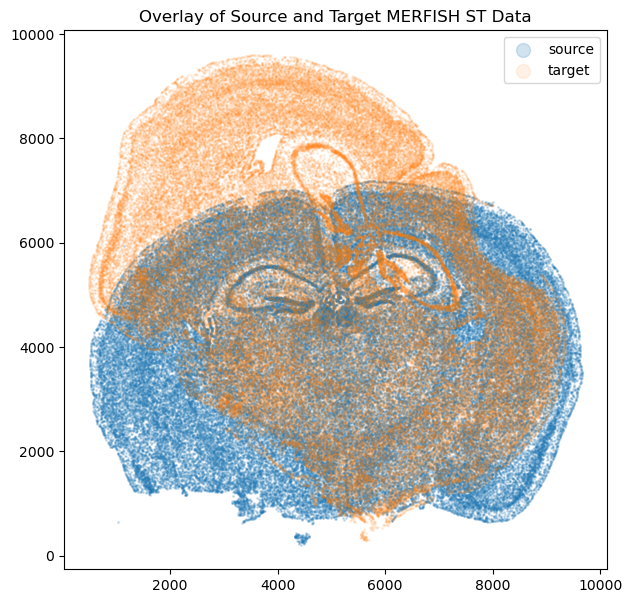

In [5]:
# STalign only needs cell centroid info, pull this 
xI = np.array(source_metadata['center_x'])
yI = np.array(source_metadata['center_y'])

xJ = np.array(target_metadata['center_x'])
yJ = np.array(target_metadata['center_y'])

# Plot 
fig,ax=plt.subplots(figsize=(7,7))
ax.scatter(xI, yI, s=1,alpha=0.2, label='source')
ax.scatter(xJ, yJ, s=1,alpha=0.1, label='target')
ax.legend(markerscale=10)
plt.title("Overlay of Source and Target MERFISH ST Data")

In [6]:
source_ad = ad.AnnData(np.array(source_gexp))
source_ad.var_names = np.array(source_gexp.columns)
source_ad.obs_names = source_gexp.index
source_ad.obsm['spatial'] = np.array([[xI[i], yI[i]] for i in range(len(xI))])

target_ad = ad.AnnData(np.array(target_gexp))
target_ad.var_names = np.array(target_gexp.columns) 
target_ad.obs_names = target_gexp.index 
target_ad.obsm['spatial'] = np.array([[xJ[i], yJ[i]] for i in range(len(xJ))])

In [7]:
#((85958, 649), (84172, 649))
source_ad.shape, target_ad.shape

((85958, 649), (84172, 649))

In [8]:
# sc.pp.filter_cells(target_ad, min_genes=100)
# sc.pp.filter_genes(target_ad, min_cells=3)
# sc.pp.filter_cells(source_ad, min_genes=100)
# sc.pp.filter_genes(source_ad, min_cells=3)

source_ad.X = source_ad.X.astype(np.float64)
target_ad.X = target_ad.X.astype(np.float64)

sc.pp.normalize_total(source_ad, target_sum=1e4)
sc.pp.log1p(source_ad)

sc.pp.normalize_total(target_ad, target_sum=1e4)
sc.pp.log1p(target_ad)

# calculate highly variable genes (HVGs)
sc.pp.highly_variable_genes(source_ad)
sc.pp.highly_variable_genes(target_ad)

# extract top 500 variable genes for source and target 
genes_tI = np.array(source_ad.var['highly_variable'][source_ad.var['highly_variable']==True][0:500].index.values)
genes_tJ = np.array(target_ad.var['highly_variable'][target_ad.var['highly_variable']==True][0:500].index.values)

# find intersecting highly variable genes (85 total) 
genes_int = np.intersect1d(genes_tI, genes_tJ)

dfI = pd.DataFrame(source_ad.X, columns=source_ad.var.index)
dfJ = pd.DataFrame(target_ad.X, columns=target_ad.var.index)

indicesI = [index for index, value in enumerate(source_ad.var.index) if value in genes_int]
indicesJ = [index for index, value in enumerate(target_ad.var.index) if value in genes_int]

# subsetted dataframe of gene exp data (cells by genes) 
GI = dfI.iloc[:,indicesI]
GJ = dfJ.iloc[:,indicesJ]

# get list of length 2 for x and y coords 
list_I = [source_ad.obsm['spatial'][:,0],source_ad.obsm['spatial'][:,1]]
list_J = [target_ad.obsm['spatial'][:,0],target_ad.obsm['spatial'][:,1]]

In [9]:
GI.shape, GJ.shape

((85958, 68), (84172, 68))

### Rasterize based on intersect HVGs using lower resolution (`dx=30`)

In [11]:
# Rasterize all genes 
XgI, Y, XI, YI = rasterizeByGene(list_I[0], # x coordinates of cells in Dataset I 
                                   list_I[1], # y coordinates of cells in Dataset I
                                   GI, # cell by gene matrix for Dataset I 
                                   dx=30, 
                                   blur=1.5)

0 out of 68 genes rasterized.
10 out of 68 genes rasterized.
20 out of 68 genes rasterized.
30 out of 68 genes rasterized.
40 out of 68 genes rasterized.
50 out of 68 genes rasterized.
60 out of 68 genes rasterized.


In [12]:
XgJ, Y, XJ, YJ = rasterizeByGene(list_J[0], 
                                   list_J[1], 
                                   GJ, 
                                   dx=30, 
                                   blur=1.5)

0 out of 68 genes rasterized.
10 out of 68 genes rasterized.
20 out of 68 genes rasterized.
30 out of 68 genes rasterized.
40 out of 68 genes rasterized.
50 out of 68 genes rasterized.
60 out of 68 genes rasterized.


In [13]:
X, Y, XctI = rasterize(list_I[0], list_I[1]) # Xct cell type density images 
X, Y, XctJ = rasterize(list_J[0], list_J[1])

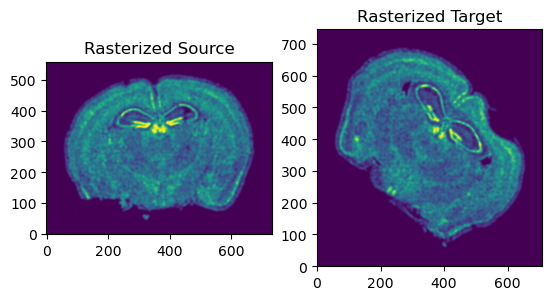

In [15]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(XctI[0], vmax = 1)
ax[0].invert_yaxis()
ax[0].set_title('Rasterized Source')
ax[1].imshow(XctJ[0], vmax = 1)
ax[1].invert_yaxis()
ax[1].set_title('Rasterized Target')
plt.show()

In [16]:
select_hvgs = [22,33,40,42]

22 Gene: Gpr182


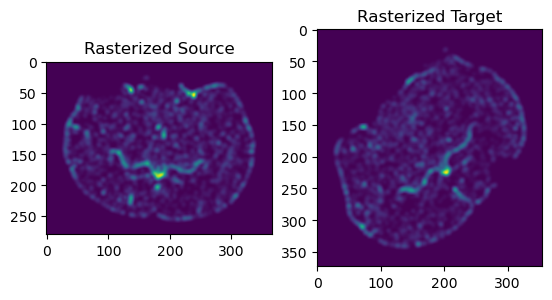

33 Gene: Tacr3


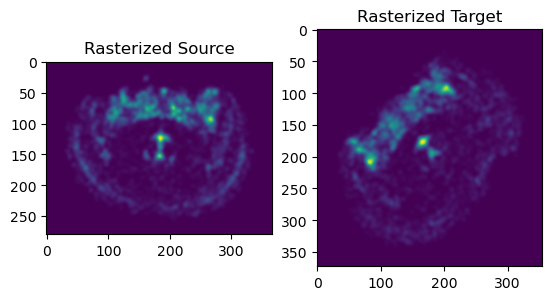

40 Gene: Gpr151


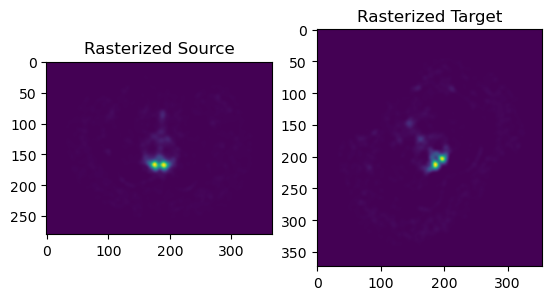

42 Gene: Ptgdr


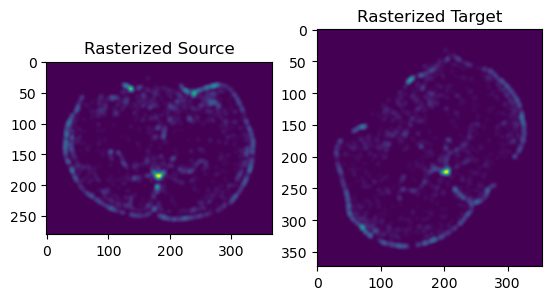

In [24]:
for i in select_hvgs:
    print(i,"Gene:", GI.columns[i])
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(XgI[i])
    ax[0].set_title("Rasterized Source")
    ax[1].imshow(XgJ[i])
    ax[1].set_title("Rasterized Target")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


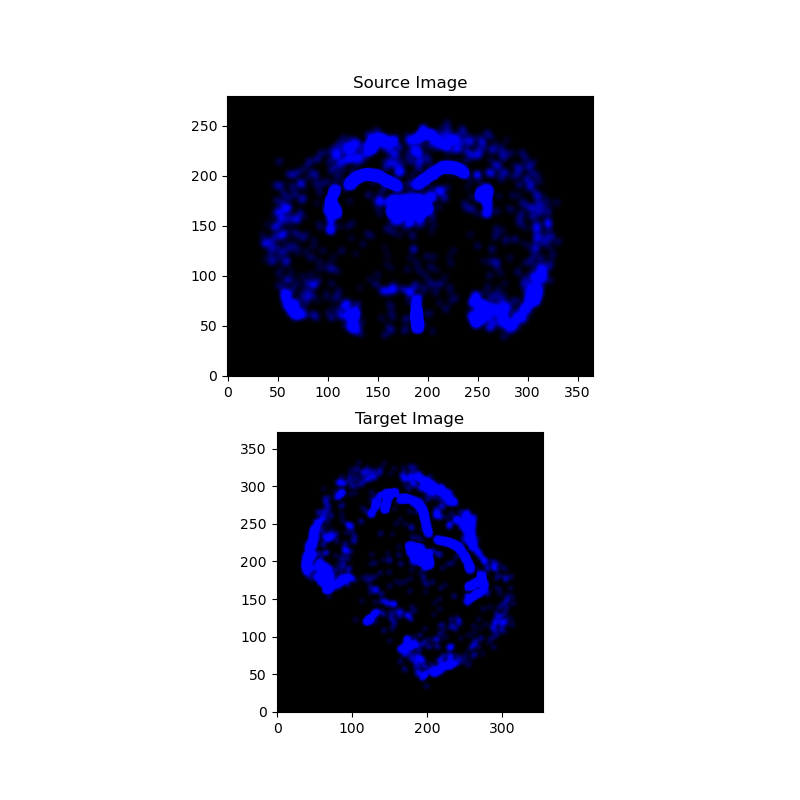

Recorded points:
Source: [[174, 238]]
Target: [[248, 269]]
Recorded points:
Source: [[174, 238], [183, 44]]
Target: [[248, 269], [114, 119]]
Recorded points:
Source: [[174, 238], [183, 44], [178, 186]]
Target: [[248, 269], [114, 119], [206, 232]]
Recorded points:
Source: [[174, 238], [183, 44], [178, 186], [36, 142]]
Target: [[248, 269], [114, 119], [206, 232], [75, 307]]
Recorded points:
Source: [[174, 238], [183, 44], [178, 186], [36, 142], [330, 149]]
Target: [[248, 269], [114, 119], [206, 232], [75, 307], [284, 88]]
Recorded points:
Source: [[174, 238], [183, 44], [178, 186], [36, 142], [330, 149], [65, 57]]
Target: [[248, 269], [114, 119], [206, 232], [75, 307], [284, 88], [33, 186]]
Recorded points:
Source: [[174, 238], [183, 44], [178, 186], [36, 142], [330, 149], [65, 57], [286, 43]]
Target: [[248, 269], [114, 119], [206, 232], [75, 307], [284, 88], [33, 186], [191, 42]]
Final Source Points: [[174, 238], [183, 44], [178, 186], [36, 142], [330, 149], [65, 57], [286, 43]]
Final T

In [27]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Label

Xg1 = XgI
Xg2 = XgJ
# Normalize your gene expression images
img1 = (Xg1[0] - np.min(Xg1[0])) / (np.max(Xg1[0]) - np.min(Xg1[0]))
img2 = (Xg2[0] - np.min(Xg2[0])) / (np.max(Xg2[0]) - np.min(Xg2[0]))

# Convert to RGB for display (blue channel)
img1_rgb = np.zeros((img1.shape[0], img1.shape[1], 3))
img2_rgb = np.zeros((img2.shape[0], img2.shape[1], 3))
img1_rgb[:, :, 2] = img1 * 50   # scale if needed for visibility
img2_rgb[:, :, 2] = img2 * 50

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].set_title("Source Image")
ax[1].set_title("Target Image")

# Display images

im1_artist = ax[0].imshow(img1_rgb, vmin=0, vmax=10000)
im2_artist = ax[1].imshow(img2_rgb, vmin=0, vmax=10000)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

# State dictionary
state = {
    'x1': None, 'y1': None,
    'x2': None, 'y2': None,
    'point': 0,
    'source_pts': [],
    'target_pts': []
}

# Label for instructions
label = Label(value="Click a landmark in the Source Image.")

# Click handler
def onclick(event):
    if event.inaxes == ax[0]:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x1'], state['y1'] = ix, iy
        state['point'] = 1
        label.value = "Click the corresponding landmark in the Target Image."
        ax[0].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()
    elif event.inaxes == ax[1] and state['point'] == 1:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x2'], state['y2'] = ix, iy
        state['point'] = 2
        label.value = "Press 'Record Landmark' to save this pair."
        ax[1].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()

# Record landmark button
def record_landmark(btn):
    if state['point'] == 2:
        state['source_pts'].append([state['x1'], state['y1']])
        state['target_pts'].append([state['x2'], state['y2']])
        state['point'] = 0
        label.value = "Click a landmark in the Source Image."
        print("Recorded points:")
        print("Source:", state['source_pts'])
        print("Target:", state['target_pts'])

# Done button
def done_selection(btn):
    label.value = f"Landmark selection finished. Total points: {len(state['source_pts'])}"
    print("Final Source Points:", state['source_pts'])
    print("Final Target Points:", state['target_pts'])
    fig.canvas.mpl_disconnect(cid)

# Create buttons
record_btn = Button(description="Record Landmark")
done_btn = Button(description="Done")
record_btn.on_click(record_landmark)
done_btn.on_click(done_selection)

# Connect click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Display buttons
display(VBox([label, HBox([record_btn, done_btn])]))

plt.show()

In [28]:
source_pts = state['source_pts']
target_pts = state['target_pts']
# source_points = np.array(source_points)
# target_points = np.array(target_points)
source_pts, target_pts

([[174, 238],
  [183, 44],
  [178, 186],
  [36, 142],
  [330, 149],
  [65, 57],
  [286, 43]],
 [[248, 269],
  [114, 119],
  [206, 232],
  [75, 307],
  [284, 88],
  [33, 186],
  [191, 42]])

In [29]:
#import STalign 
pointsI = np.zeros([len(source_pts),2])
pointsJ = np.zeros([len(source_pts),2])

# np.max(np.array(source_pts)[:,0])-
pointsI[:,1] = np.array(XI[np.array(source_pts)[:,0]])
pointsI[:,0] = np.array(YI[np.array(source_pts)[:,1]])
pointsJ[:,1] = np.array(XJ[np.array(target_pts)[:,0]])
pointsJ[:,0] = np.array(YJ[np.array(target_pts)[:,1]])

L,T = L_T_from_points(pointsI,pointsJ)
A = to_A(torch.tensor(L),torch.tensor(T))

Xct1 = (XctI - np.min(XctI))/(np.max(XctI)-np.min(XctI))
Xct2 = (XctJ - np.min(XctJ))/(np.max(XctJ)-np.min(XctJ))

Xg1 = (Xg1 - np.min(Xg1))/(np.max(Xg1)-np.min(Xg1))
Xg2 = (Xg2 - np.min(Xg2))/(np.max(Xg2)-np.min(Xg2))

In [30]:
pointsI, pointsJ

(array([[6649.896541  , 4813.79585937],
        [ 829.896541  , 5083.79585937],
        [5089.896541  , 4933.79585937],
        [3769.896541  ,  673.79585937],
        [3979.896541  , 9493.79585937],
        [1219.896541  , 1543.79585937],
        [ 799.896541  , 8173.79585937]]),
 array([[7425.28861376, 7042.61398356],
        [2925.28861376, 3022.61398356],
        [6315.28861376, 5782.61398356],
        [8565.28861376, 1852.61398356],
        [1995.28861376, 8122.61398356],
        [4935.28861376,  592.61398356],
        [ 615.28861376, 5332.61398356]]))

In [51]:
def LDDMM_core(xI,I,xJ,J,Ig, Jg, pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaMg=1.0, sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
 
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    Jg = torch.tensor(Jg,device=device,dtype=dtype)
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand # WHY DO IT THIS WAY??
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)] # "a" determines step size of velocity field
        XV = torch.stack(torch.meshgrid(xv),-1) #creating a meshgrid to apply transformation to all points in a grid (creating the 'field' in velocity field)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True) # why does XW have a shape of 3 (aren't there only x and y points? 2D)
        #velocity field start out as a zero vector field - how does it get updated? 
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv) #for plotting purposes
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype) #step in between each set of points
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)] # 5 dimensions of grid of XV/dv - should be similar to XV but not a meshgrid, just points along each axis
    extentF = extent_from_x(fv) #plotting
    FV = torch.stack(torch.meshgrid(fv),-1) # would this not just be the same as XV? print out both and compare 
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0) #smoothing kernel? what is this?

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,5)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        #print(Xs.shape)
        # transform image
        #AI = interp(xI,I.swapaxes(1,2),Xs.permute(2,1,0),padding_mode="border")
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")
        AIg = interp(xI,Ig,Xs.permute(2,0,1),padding_mode="border")
        #AI = AI.permute(0,2,1)
        #print(AI.shape)
        #print(J.shape)
        if it == 0:
            AI_orig = AIg.clone().detach()
            # Resize Jg so it matches AIg size
            Jg_resized = F.interpolate(
                Jg.unsqueeze(0), 
                size=AIg.shape[1:], 
                mode='bilinear', 
                align_corners=False
            ).squeeze(0)

            # Resize WM (single-channel!) safely
            WM_resized = F.interpolate(
                WM[None, None],        # (1,1,H,W)
                size=AIg.shape[1:], 
                mode='nearest'
            ).squeeze(0).squeeze(0)
        # objective function
        # use resized Jg and WM (if present). If not present yet, fall back to original
        if 'Jg_resized' in locals() and 'WM_resized' in locals():
            EMg = torch.sum((AIg - Jg_resized)**2 * WM_resized) / (2.0 * sigmaMg**2)
        else:
            EMg = torch.sum((AIg - Jg)**2 * WM) / (2.0 * sigmaMg**2)
        
        EM = torch.sum((AI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER + EMg
        tosave = [E.item(), EM.item(), ER.item(), EMg.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.9
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        "AI": AI.clone().detach(), # the ST-aligned source image 
        "pointsIt": pointsIt.clone().detach(), # final aligned points 
        "E": np.array(Esave)
    }

### Hyperparameter optimization 

In [47]:
!pip install "ray[tune]" optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [optuna]2m4/5 [optuna]]


In [42]:
from ray import tune 

# Define the search space 
search_space = {
    "sigmaM": tune.loguniform(0.1, 10.0),
    "sigmaMg": tune.loguniform(0.1, 10.0),
    # "epL": tune.loguniform(1e-6, 1e-2),
    # "epT": tune.loguniform(1e-3, 1e-1),
    # "epV": tune.loguniform(1e-3, 1e-1),
    # "p": tune.choice([1.0, 2.0]),
    "niter": tune.choice([100, 200]), # short pilot runs 
    "a": tune.loguniform(50.0, 500.0)
}

In [67]:
def lddmm_tune_fn(config, pointsI_ref, pointsJ_ref, xI_ref, I_ref, xJ_ref, J_ref, Ig_ref, Jg_ref):
    """
    config: dict passed from Tune with hyperparams
    points*_ref: ray.put references to large arrays
    """
    # Retrieve data from object store
    pointsI = ray.get(pointsI_ref)
    pointsJ = ray.get(pointsJ_ref)
    xI = ray.get(xI_ref)
    I = ray.get(I_ref)
    xJ = ray.get(xJ_ref)
    J = ray.get(J_ref)
    Ig = ray.get(Ig_ref)
    Jg = ray.get(Jg_ref)

    try:
        out = LDDMM_core(
            # sigmaM=config["sigmaM"],
            # sigmaMg=config["sigmaMg"],
            niter=int(config["niter"]),
            a=config['a'],
            pointsI=pointsI,
            pointsJ=pointsJ,
            xI=xI, I=I,
            xJ=xJ, J=J,
            Ig=Ig, Jg=Jg,
            sigmaM=0.25, 
            sigmaMg=0.25
        )
    except Exception:
        # If anything fails, report very high energy so tuning avoids this config
        tune.report(E=1e12)
        return

    last = out["E"][-1]
    tune.report(
        E=float(last[0]),
        EM=float(last[1]),
        ER=float(last[2]),
        EMg=float(last[3]) if len(last) > 3 else float("nan"),
        EP=float(last[4]) if len(last) > 4 else float("nan")
    )

In [ ]:
import ray
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
from ray.tune.search.optuna import OptunaSearch

# Define the search space 
search_space = {
    # "epL": tune.loguniform(1e-6, 1e-2),
    # "epT": tune.loguniform(1e-3, 1e-1),
    # "epV": tune.loguniform(1e-3, 1e-1),
    # "p": tune.choice([1.0, 2.0]),
    "niter": tune.choice([30, 50]), # short pilot runs 
    "a": tune.uniform(50.0, 60.0)
}

scheduler = ASHAScheduler(
    metric="E",
    mode="min",
    max_t=50, # use same scale as niter 
    grace_period=50,
    reduction_factor=3
)

# optional Bayesian searcher (Optuna)
search_alg = OptunaSearch(metric="E", mode="min")

storage_path = '/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/raytune_results_lddmm'

pointsI_ref = ray.put(pointsI)
pointsJ_ref = ray.put(pointsJ)
xI_ref = ray.put([YI, XI])
I_ref = ray.put(XctI)
xJ_ref = ray.put([YJ, XJ])
J_ref = ray.put(XctJ)
Ig_ref = ray.put(Xg1[select_hvgs, :, :])
Jg_ref = ray.put(Xg2[select_hvgs, :, :])

analysis = tune.run(
    lambda cfg: lddmm_tune_fn(cfg, pointsI_ref, pointsJ_ref, xI_ref, I_ref, xJ_ref, J_ref, Ig_ref, Jg_ref),
    config=search_space,
    num_samples=30,
    scheduler=scheduler,
    search_alg=search_alg,
    resources_per_trial={"cpu": 4},
    storage_path=storage_path
)


2025-12-11 16:37:28,056	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2025-12-11 16:37:28,075] A new study created in memory with name: optuna


In [45]:
os.getcwd()

'/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression'